# Import dependencies

In [352]:

import datetime
import itertools
import json
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Data Visualization
import seaborn as sns
# Model Evaluation Libraries
from sklearn.metrics import accuracy_score
# Tuning & Splitting Libraries
from sklearn.model_selection import train_test_split

# Data Manipulations
# Loading Classifiers
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight

sns.set_style('darkgrid')
sns.color_palette('pastel')



[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

# Load data

In [285]:
# Reading text from txt file
zip_file_path = '../data/transactions_compressed.txt.zip'
file_name_to_extract = 'transactions.txt'

# Open zip and extract file by name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name_to_extract) as extracted_file:
        lines = extracted_file.readlines()
lines = [line.decode('utf-8').strip() for line in lines]

# Text in text file was in JSON format
# Converting text lines to JSON format and then restructuring as a dataframe 
trxn_data = []
for line in lines:
    trxn_data.append(json.loads(line))

# Replacing blank fields with NaN values
df = pd.DataFrame(trxn_data)
df = df.replace(r'', np.NaN)
print('Data has been successfully loaded.')

Data has been successfully loaded.


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\143919823.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r'', np.NaN)


# EDA - exploratory data analyze

In [ ]:
# Look on the top of dataset

df.head(10)

In [290]:
def simple_eda(df):
    """
    A simple exploratory data analysis (EDA) function to summarize a dataset.
    
    Parameters:
    df : pandas.DataFrame
        The input DataFrame to be analyzed.
    
    Prints:
    - Dimensions of the dataset (rows and columns)
    - Total missing values (NA's)
    - Information about duplicates (if any)
    - Data type, distinct count, and missing values for each column
    """
    total_na = df.isna().sum().sum()
    col_name = df.columns
    dtypes = df.dtypes
    uniq = df.nunique()
    na_val = df.isna().sum()
    duplicate_indices = df[df.duplicated()].index
    
    print(f'Dimensions: {df.shape[0]} rows, {df.shape[1]} columns')
    print(f'Total NA\'s: {total_na}')
    
    if len(duplicate_indices) > 0:
        print(f'Duplicate rows indices: {duplicate_indices}')
    else:
        print('There are no duplicates in this dataset!')
    
    print(f"{'Column Name':<38} {'Data Type':<10} {'Count Distinct':<15} {'NA Values':<10}")
    
    for i in range(len(df.columns)):
        dtype = str(dtypes[i])
        distinct_count = uniq[i]
        na_count = na_val[i]
        
        # Handle object types for proper formatting
        if dtype == 'object':
            print(f"{col_name[i]:<38} {dtype:<10} {distinct_count:<15} {na_count:<10}")
        else:
            print(f"{col_name[i]:<38} {dtype:<10} {distinct_count:<15} {na_count:<10}")


In [291]:
simple_eda(df)

Dimensions: 786363 rows, 29 columns
Total NA's: 4728625
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
customerId                             object     5000            0         
creditLimit                            float64    10              0         
availableMoney                         float64    521916          0         
transactionDateTime                    object     776637          0         
transactionAmount                      float64    66038           0         
merchantName                           object     2490            0         
acqCountry                             object     4               4562      
merchantCountryCode                    object     4               724       
posEntryMode                           object     5               4054      
posConditionCode                       object     3     

C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


## Dataset Column Descriptions:

1. **`accountNumber`**:  
   The account number related to the transaction.

2. **`customerId`**:  
   A unique identifier for the customer.

3. **`creditLimit`**:  
   The credit limit of the customer’s account, indicating the maximum amount they are allowed to spend.

4. **`availableMoney`**:  
   The available funds on the customer’s account at the time of the transaction. `availableMoney=creditLimit−currentBalance`

5. **`transactionDateTime`**:  
   The date and time when the transaction occurred.

6. **`transactionAmount`**:  
   The amount of money involved in the transaction.

7. **`merchantName`**:  
   The name of the merchant where the transaction took place.

8. **`acqCountry`**:  
   The country where the payment instrument (e.g., card) was issued.

9. **`merchantCountryCode`**:  
   The country code of the merchant’s location.

10. **`posEntryMode`**:  
    Describes how the card details were entered at the point of sale (e.g., chip, magnetic stripe, manual entry).

11. **`posConditionCode`**:  
    The condition at the point of sale during the transaction (e.g., whether the card was physically present or not) ???

12. **`merchantCategoryCode`**:  
    A code that represents the category of the merchant’s business (e.g., restaurant, clothing store).

13. **`currentExpDate`**:  
    The current expiration date of the card involved in the transaction.

14. **`accountOpenDate`**:  
    The date when the customer’s account was opened.

15. **`dateOfLastAddressChange`**:  
    The last time the customer changed their address.

16. **`cardCVV`**:  
    The CVV code associated with the card used for the transaction.

17. **`enteredCVV`**:  
    The CVV code entered by the customer during the transaction.

18. **`cardLast4Digits`**:  
    The last 4 digits of the card used in the transaction. Used to identify the specific card in use.

19. **`transactionType`**:  
    The type of transaction (e.g., PURCHASE, REVERSAL, ADDRESS_VERIFICATION).

20. **`echoBuffer`**:  
    A technical field that might contain auxiliary information related to the transaction.

21. **`currentBalance`**:  
    This is the customer's current credit card debt—the amount that needs to be repaid. It increases with each new transaction and decreases as the debt is paid off. `currentBalance=creditLimit−availableMoney`

22. **`merchantCity`**:  
    The city where the merchant is located.

23. **`merchantState`**:  
    The state where the merchant is located (applicable mostly to U.S. transactions).

24. **`merchantZip`**:  
    The postal code of the merchant's location.

25. **`cardPresent`**:  
    Indicates whether the physical card was present during the transaction (`True`/`False`).

26. **`posOnPremises`**:  
    Specifies whether the transaction occurred on the merchant’s premises or remotely (e.g., online).

27. **`recurringAuthInd`**:  
    Indicates whether the transaction is part of a recurring authorization (e.g., subscription).

28. **`expirationDateKeyInMatch`**:  
    Indicates if the entered expiration date matches the card’s actual expiration date (`True`/`False`).

29. **`isFraud`**:  
    A label indicating whether the transaction is fraudulent (`True`/`False`). This is the target variable for  anomaly detection model.


In [292]:
# Rename column current balance to credit debt. It is more appropriate name
df = df.rename(columns={"currentBalance": "creditDebt"})
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,creditDebt,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,09,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,02,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,09,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


## Drop useless/empty columns

In [293]:
df = df.drop(
    columns={'recurringAuthInd', 'posOnPremises', 'merchantName', 'merchantZip', 'merchantState', 'merchantCity',
             'echoBuffer', 'cardLast4Digits'})
simple_eda(df)

Dimensions: 786363 rows, 21 columns
Total NA's: 10447
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
customerId                             object     5000            0         
creditLimit                            float64    10              0         
availableMoney                         float64    521916          0         
transactionDateTime                    object     776637          0         
transactionAmount                      float64    66038           0         
acqCountry                             object     4               4562      
merchantCountryCode                    object     4               724       
posEntryMode                           object     5               4054      
posConditionCode                       object     3               409       
merchantCategoryCode                   object     19      

C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


In [294]:
# On the surface it seems that column accountNumber equals customerId. 
# So if it is true - let`s drop one of them

if (len(df[df.accountNumber != df.customerId]) == 0):
    df = df.drop(columns={'customerId'})
    simple_eda(df)

Dimensions: 786363 rows, 20 columns
Total NA's: 10447
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
availableMoney                         float64    521916          0         
transactionDateTime                    object     776637          0         
transactionAmount                      float64    66038           0         
acqCountry                             object     4               4562      
merchantCountryCode                    object     4               724       
posEntryMode                           object     5               4054      
posConditionCode                       object     3               409       
merchantCategoryCode                   object     19              0         
currentExpDate                         object     165     

C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


## Visualize null values

In [ ]:

plt.figure(figsize=(15, 6))
df.isnull().sum().plot(kind='barh', color='black')
plt.xlabel('Count of Missing Values', fontsize=14)
plt.ylabel('Attributes', fontsize=14)
plt.title('Count of Missing Values vs Attributes', fontsize=18)
plt.show()

## Analyze categorical features

In [ ]:
# The most null values in categorical features, so let`s analyze them

categorical_columns = ['transactionType', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'isFraud',
                       'posConditionCode', 'merchantCategoryCode', 'expirationDateKeyInMatch', 'cardPresent']
melted = df[categorical_columns].melt(var_name='column', value_name='value')
value_counts = melted.value_counts().reset_index(name='counts')
sorted_df = value_counts.sort_values(by=['column', 'counts'])

sorted_df

In [ ]:
# Visualize categorical features

def show_pie_distribution_in_categorical_features(df, categorical_columns, title='Distribution of'):
    num_columns = len(categorical_columns)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(6, 4 * num_columns))
    for i, col in enumerate(categorical_columns):
        category_counts = df[col].value_counts()
        colors = plt.cm.Paired(range(len(category_counts)))
        axes[i].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
        axes[i].set_title(title + ' ' + col)
        axes[i].axis('equal')
    plt.tight_layout()
    plt.show()

In [ ]:
# Split on fraud and non-fraud df
fraudDf = df[df['isFraud'] == True]
nonFraudDf = df[df['isFraud'] == False]

In [ ]:
show_pie_distribution_in_categorical_features(df, categorical_columns, title='Distribution in general dataset of')

In [ ]:
show_pie_distribution_in_categorical_features(fraudDf, categorical_columns, title='Distribution in fraud dataset of')

In [ ]:
show_pie_distribution_in_categorical_features(nonFraudDf, categorical_columns, title='Distribution in fraud dataset of')

## Analyze discrete features

In [ ]:
# Define discrete columns

discrete_columns = ["creditLimit", "availableMoney", "transactionAmount", "creditDebt"]
df.describe()

In [295]:
# Convert transactionDateTime column to datetime type for comfortable analying work with it

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
# Visualizing discrete columns statistics using hists to see distribution

fig, axs = plt.subplots(2, 2, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.5, wspace=.001)

palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), discrete_columns, palette):
    sns.histplot(data=df, x=df[field], ax=ax, color=color, kde=True)
    ax.set_title('Histograms of ' + str(field), fontsize=20)
    ax.set_xlabel(str(field), fontsize=17)
    ax.set_ylabel('Count', fontsize=17)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.tight_layout()

In [ ]:
# Visualizing discrete columns statistics using Box-plot to see deviation

fig, axs = plt.subplots(1, 4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.5, wspace=.001)

palette = ["#9736FF", "#8992F3", "#B29800", "#80004C"]
for ax, field, color in itertools.zip_longest(axs.ravel(), discrete_columns, palette):
    sns.boxplot(data=df, y=df[field], ax=ax, color=color)
    ax.set_title('Boxplot of ' + str(field), fontsize=16)
    plt.tight_layout()
plt.show()

In [ ]:
# Check discrete columns correlation

corr = df[discrete_columns].corr()
sns.heatmap(corr, cmap="Reds", annot=True)

In [ ]:
# Check records where availableMoney column has negative values

df[df['availableMoney'] < 0].describe()

In [ ]:
# Check transaction with amount 0 grouping by type

df[df['transactionAmount'] == 0].transactionType.value_counts().sort_values(ascending=False)

In [ ]:
# Check count of frauds by transaction type where amount equals 0

zero_amount_fraud = df[(df['transactionAmount'] == 0) & (df['isFraud'] == True)]

fraud_count_per_transaction_type = zero_amount_fraud.groupby('transactionType').size()

fraud_count_per_transaction_type

In [ ]:
zero_amount_fraud

In [ ]:
# Check if ADDRESS_VERIFICATION typed transactions has only zero transaction amount

print(len(df[(df['transactionType'] == 'ADDRESS_VERIFICATION') & (df['transactionAmount'] != 0)]) == 0)

In [ ]:
# Analysis of the case when the credit debt first grows and then instantly drops to 0. Based on this 
# analysis and graph, we can conclude that the dataset does not provide a record of the intermediate
# transaction of repaying the credit debt. This graph shows the balanced repayment of credit debt by the
# base client who has no cases of fraud

accountNumber = '574788567'
specific_account_df = df[df['accountNumber'] == accountNumber]
specific_account_df.sort_values('transactionDateTime')


def plot_available_money_and_credit_debt(df, customer_id):
    """
    Plots the available money and credit debt over time for a specific customer.

    Args:
    - df (DataFrame): DataFrame containing the data.
    - transaction_date_column (str): The column name for transaction date.
    - available_money_column (str): The column name for available money.
    - credit_debt_column (str): The column name for credit debt.
    - customer_id (int/str): ID of the specific customer.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(pd.to_datetime(df['transactionDateTime']), df['availableMoney'], marker='o', linestyle='-', color='b',
             label='Available Money')
    plt.plot(pd.to_datetime(df['transactionDateTime']), df['creditDebt'], marker='x', linestyle='--', color='g',
             label='Credit debt')

    plt.title(f'Available Money and Credit Debt Over Time for account by number {customer_id}')
    plt.xlabel('Transaction DateTime')
    plt.ylabel('Amount')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


plot_available_money_and_credit_debt(specific_account_df, accountNumber)

In [ ]:
df.creditLimit.describe()

In [ ]:
# Graphs visualize the number of fraud cases at different credit limit ranges

q1 = df['creditLimit'].quantile(0.25)
q2 = df['creditLimit'].quantile(0.50)
q3 = df['creditLimit'].quantile(0.75)

# Add new column with credit limit range 
df['creditLimitRange'] = pd.cut(df['creditLimit'], bins=[-float('inf'), q1, q2, q3, float('inf')],
                                labels=['0-25%', '25-50%', '50-75%', '75-100%'])

# Calculate fraud records count by each range
fraud_counts = df[df['isFraud'] == True].groupby('creditLimitRange').size()

# Calculate general records count by each range
total_counts = df.groupby('creditLimitRange').size()

# Calculate percentage
fraud_percentage = (fraud_counts / total_counts) * 100

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Count graph of fraud cases
ax[0].bar(fraud_counts.index, fraud_counts.values, color='skyblue')
ax[0].set_title('Number of Fraud Cases by Credit Limit Range')
ax[0].set_xlabel('Credit Limit Range')
ax[0].set_ylabel('Number of Fraud Cases')

# Percentage graph of fraud cases
ax[1].bar(fraud_percentage.index, fraud_percentage.values, color='lightcoral')
ax[1].set_title('Percentage of Fraud Cases by Credit Limit Range')
ax[1].set_xlabel('Credit Limit Range')
ax[1].set_ylabel('Percentage of Fraud Cases (%)')

plt.tight_layout()
plt.show()


## Analyze datetime columns

In [296]:
# Check if dataset contains transactions with expired card

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], format='%Y-%m-%dT%H:%M:%S')
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%m/%Y', errors='coerce')

df_filtered = df[
    (df['transactionDateTime'].dt.year > df['currentExpDate'].dt.year) |
    ((df['transactionDateTime'].dt.year == df['currentExpDate'].dt.year) &
     (df['transactionDateTime'].dt.month > df['currentExpDate'].dt.month))
    ]
print(f'Dataset contains transactions with expired card - {len(df_filtered) > 0}')


Dataset contains transactions with expired card - False


In [ ]:
def analyze_fraud_by_address_change(df, threshold):
    """
    Analyze fraud rate based on the frequency of address changes.

    Parameters:
    df (pd.DataFrame): The dataset containing transactions.
    threshold (int): The minimum number of address changes to consider.

    Prints:
    - Number of accounts with frequent address changes.
    - Fraud rate among these accounts.
    """

    # Convert columns with dates to datetime format
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

    # Group by accountNumber and count the number of unique address changes
    address_change_counts = df.groupby('accountNumber')['dateOfLastAddressChange'].nunique()

    # Filter accounts with address changes greater than the threshold
    frequent_address_changers = address_change_counts[address_change_counts > threshold].index

    # Filter transactions for accounts with frequent address changes
    frequent_change_transactions = df[df['accountNumber'].isin(frequent_address_changers)]

    # Calculate fraud rate among these accounts
    fraud_rate = frequent_change_transactions['isFraud'].mean()

    # Print the results
    print(f"Number of accounts with address changes greater than {threshold}: {len(frequent_address_changers)}")
    print(f"Fraud rate among accounts with address changes greater than {threshold}: {fraud_rate * 100:.2f}%")

    return fraud_rate * 100


def visualize_fraud_vs_address_changes(df, thresholds):
    """
    Visualize the fraud rate for different thresholds of address changes.
    
    Parameters:
    df (pd.DataFrame): The dataset containing transactions.
    thresholds (list of int): List of address change thresholds to evaluate.
    """

    fraud_rates = []

    for threshold in thresholds:
        fraud_rate = analyze_fraud_by_address_change(df, threshold)
        fraud_rates.append(fraud_rate)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fraud_rates, marker='o', linestyle='-', color='b')
    plt.title('Fraud Rate vs Address Change Threshold')
    plt.xlabel('Address Change Threshold (times)')
    plt.ylabel('Fraud Rate (%)')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.show()


thresholds = [0, 3, 5, 7, 10, 15, 20, 30, 40, 50]
visualize_fraud_vs_address_changes(df, thresholds)

# Feature Engineering and Data Processing for Model Building

### Adding Synthetic Replenishment Data for Accurate Calculation of Credit Debt Repayment Stability (CDRS) Ratio

Before calculating the Credit Debt Repayment Stability (CDRS) ratio, it is crucial to account for all transactions affecting the available balance, especially replenishments. However, the dataset lacks direct information on replenishment transactions, except for specific cases like reversal transactions. This absence introduces potential inaccuracies when calculating repayment stability.

To resolve this issue without altering the data schema by adding new markers, we will synthetically generate missing replenishment transactions. The approach works as follows:

1. **Data Grouping and Sorting**: We group the transactions by account number and arrange them in chronological order to establish a clear transaction flow.
   
2. **Pairwise Transaction Comparison**: After sorting, we compare each transaction with the preceding one. If the available balance of the current transaction exceeds that of the previous one and the previous transaction is not classified as a reversal or address verification, we infer that a replenishment transaction was missing between the two.

3. **Synthetic Replenishment Insertion**: For each identified gap, a synthetic replenishment transaction is inserted with a calculated amount and timestamp. This ensures that all changes in the available balance are accurately reflected in the dataset, allowing for a more precise calculation of the CDRS ratio.

By synthesizing replenishment data in this way, we can achieve a more accurate and realistic assessment of credit debt 
repayment behavior without distorting the original dataset's structure.


In [297]:
def add_skipped_replenishment_transactions(df):
    """
    Adds synthetic replenishment transactions to a DataFrame of financial transactions.

    The method processes transaction data for each account, ensuring replenishment transactions 
    are inserted when missing. It works by grouping transactions by account number, 
    sorting them chronologically, and checking if a replenishment transaction is needed 
    between consecutive transactions. If the available balance of a later transaction 
    is greater than the previous one (and the previous transaction is not a reversal or address verification), 
    a replenishment transaction is added synthetically.

    Parameters:
    df (pd.DataFrame): DataFrame containing transaction data.

    Returns:
    pd.DataFrame: The original DataFrame with added synthetic replenishment transactions. 
    The output will be sorted by 'accountNumber' and 'transactionDateTime'.
    """

    # Sort data by account number and transaction datetime
    df = df.sort_values(['accountNumber', 'transactionDateTime']).reset_index(drop=True)

    # List to store new replenishment transactions
    replenishments = []

    # Group transactions by account number
    grouped = df.groupby('accountNumber')

    # Iterate over each account group
    for account, group in grouped:
        # Create a replenishment before the first transaction
        first_transaction = group.iloc[0]
        replenish_row = first_transaction.copy()
        replenish_row['transactionDateTime'] = first_transaction['transactionDateTime'] - datetime.timedelta(days=1)
        replenish_row['transactionAmount'] = first_transaction['creditLimit']
        replenish_row['enteredCVV'] = first_transaction['cardCVV']
        replenish_row['transactionType'] = 'REPLENISHMENT'
        replenish_row['isFraud'] = False
        replenishments.append(replenish_row)

        # Process the rest of the transactions
        for i in range(1, len(group)):
            current_transaction = group.iloc[i]
            previous_transaction = group.iloc[i - 1]

            # Check if a replenishment is needed between transactions
            if (current_transaction['availableMoney'] >= previous_transaction['availableMoney'] and
                    previous_transaction['transactionAmount'] != 0 and
                    previous_transaction['transactionType'] not in ['REVERSAL', 'ADDRESS_VERIFICATION']):
                # Calculate the replenishment datetime
                difference = current_transaction['transactionDateTime'] - previous_transaction['transactionDateTime']
                replenishment_transaction_date_time = (
                    current_transaction['transactionDateTime'] if difference <= datetime.timedelta(0)
                    else current_transaction['transactionDateTime'] - difference / 2
                )

                # Create replenishment transaction
                replenish_row = previous_transaction.copy()
                replenish_row['transactionDateTime'] = replenishment_transaction_date_time
                replenish_row['availableMoney'] = previous_transaction['availableMoney'] - previous_transaction[
                    'transactionAmount']
                replenish_row['creditDebt'] = previous_transaction['creditDebt'] + previous_transaction[
                    'transactionAmount']
                replenish_row['transactionAmount'] = current_transaction['availableMoney'] - replenish_row[
                    'availableMoney']
                replenish_row['enteredCVV'] = previous_transaction['cardCVV']
                replenish_row['transactionType'] = 'REPLENISHMENT'
                replenish_row['isFraud'] = False

                # Append replenishment to the list
                replenishments.append(replenish_row)

    # Convert replenishments to DataFrame and merge with the original DataFrame
    replenishment_df = pd.DataFrame(replenishments)
    result_df = pd.concat([df, replenishment_df]).sort_values(['accountNumber', 'transactionDateTime']).reset_index(
        drop=True)

    return result_df


# Example call of the function
df = add_skipped_replenishment_transactions(df)


In [298]:
# Check dimension after adding new rows

simple_eda(df)

Dimensions: 855095 rows, 20 columns
Total NA's: 11259
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
availableMoney                         float64    567356          0         
transactionDateTime                    datetime64[ns] 844414          0         
transactionAmount                      float64    106352          0         
acqCountry                             object     4               4942      
merchantCountryCode                    object     4               786       
posEntryMode                           object     5               4387      
posConditionCode                       object     3               446       
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 

C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


## Credit debt repayment stability ratio (CDRS Ratio)

### Overview
The primary goal of this analysis is to explore the relationship between a customer's spending and repayment patterns and the likelihood of fraudulent activity (`isFraud`). Specifically, we calculate a **stability coefficient** that reflects how consistently a customer closes their credit debt over time, then analyze how this coefficient correlates with fraud probability.

### Key Variables

1. **Spending Percentage**: The percentage of the credit limit that was spent between full debt repayments.
 $$ \text{Spent Percentage} = \left( \frac{\text{Total Amount Spent}}{\text{Credit Limit}} \right) \times 100 $$

2. **Days Between Resets**: The number of days between two consecutive events where the available balance equals the credit limit (i.e., the debt is fully repaid).

### Stability ratio

To measure customer stability, we consider two factors:
- The **average spending percentage** between resets.
- The **average number of days** between resets.

These two values are normalized using Min-Max normalization to bring them into the range of [0, 1]. The final stability coefficient is computed as:

$$ \text{CDRS Ratio} = 1 - (\text{Normalized Spending Percentage Between Resets} \times \text{Normalized Days Between Resets}) $$

This coefficient ranges from 0 to 1, where:
- A value closer to **1** indicates a more stable customer (less spending, more frequent repayments).
- A value closer to **0** indicates less stable repayment behavior.

### Hypothesis
We hypothesize that a higher stability coefficient (more stable customers) correlates with a lower probability of fraudulent activity. Conversely, lower stability may indicate higher fraud risk.

### Fraud Analysis
Once the CDRS Ratio is calculated for each account, we group the accounts into ranges (bins) of stability coefficients and calculate the percentage of fraudulent transactions (`isFraud = True`) in each range. The results are visualized to test the hypothesis.

### Conclusion
This analysis can help identify patterns between customer behavior and fraud risk, providing valuable insights for improving fraud detection models.

### Nice to fix and improve
- Investigate anomaly in cdrs-ratio range from 0.222-0.333 -- 0.333-0.444
- Improve scaling function (when size of input is 1)
- Investigate and fix when normalized `avg_norm_days_between_resets` is NaN (reason might be in scaling function)


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\3359331553.py:13: RuntimeWarning: invalid value encountered in divide
  return (np.array(values) - min(values)) / (max(values) - min(values))
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\3359331553.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_stats = df_merged.groupby('stability_range').agg(


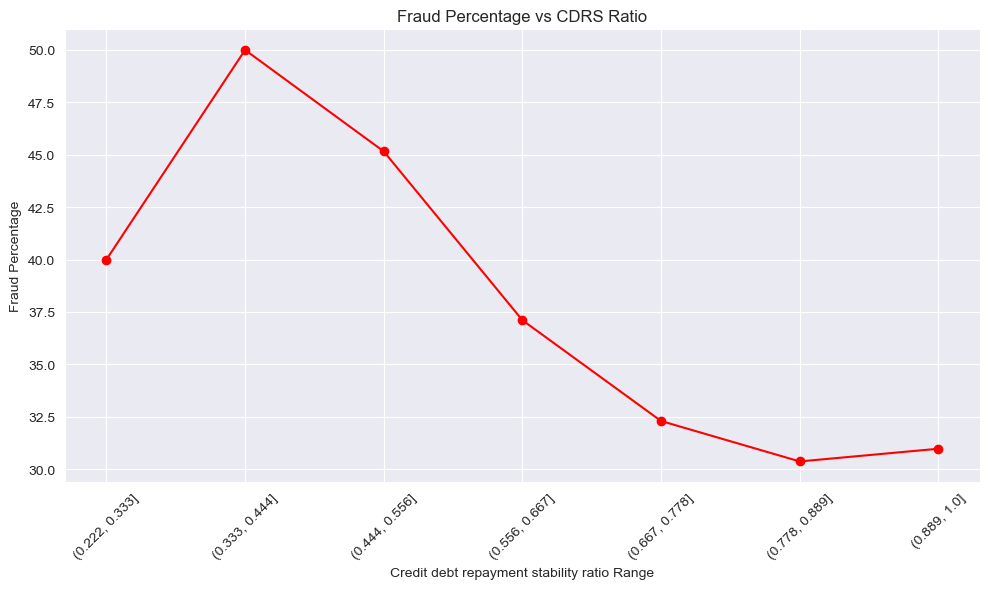

In [315]:

# Function for Min-Max normalization
def min_max_normalize(values):
    """
    Normalizes a list of values using Min-Max normalization.

    Parameters:
    values: list or array of numerical values to be normalized.

    Returns:
    Normalized numpy array of values in range [0, 1].
    """
    if len(values) > 1:
        return (np.array(values) - min(values)) / (max(values) - min(values))
    else:
        return np.array([1])


# Function to visualize fraud percentage based on stability coefficient
def visualize_fraud_vs_cdrs_ratio(fraud_stats):
    """
    Visualizes the fraud percentage based on cdrs ratio ranges.

    Parameters:
    fraud_stats: DataFrame containing fraud statistics grouped by cdrs ratio ranges.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(fraud_stats.index.astype(str), fraud_stats['fraud_percentage'], marker='o', linestyle='-', color='r')
    plt.title('Fraud Percentage vs CDRS Ratio')
    plt.xlabel('Credit debt repayment stability ratio Range')
    plt.ylabel('Fraud Percentage')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def calculate_account_stability_stats(account, transactions, reset_indices, stability_data):
    days_between_resets = []
    spent_percentages = []
    # Calculate the amount spent and days between credit limit resets
    for i in range(1, len(reset_indices)):
        start_idx = (reset_indices[i - 1]) + 1 # not include transaction of replenishment
        end_idx = (reset_indices[i]) - 1 # not include transaction of replenishment

        # Exclude replenishment transactions from the spending calculation
        transaction_slice = transactions.loc[start_idx:end_idx]
        non_replenishment_transactions = transaction_slice[
            (transaction_slice['transactionType'] != 'REPLENISHMENT') &
            (transaction_slice['transactionType'] != 'ADDRESS_VERIFICATION') &
            (transaction_slice['transactionType'] != 'REVERSAL')
        ]

        # Calculate the total amount spent between resets
        total_spent = non_replenishment_transactions['transactionAmount'].sum()
        credit_limit = transactions.loc[start_idx, 'creditLimit']

        spent_percentage = abs((total_spent / credit_limit) * 100)
        spent_percentages.append(spent_percentage)

        # Calculate the number of days between the two resets
        start_date = transactions.loc[start_idx, 'transactionDateTime']
        end_date = transactions.loc[end_idx, 'transactionDateTime']
        days_between = (end_date - start_date).days
        days_between_resets.append(days_between)

    # Normalize spent percentages and days between resets
    norm_spent_percentages = min_max_normalize(spent_percentages)
    norm_days_between_resets = min_max_normalize(days_between_resets)
    # Calculate the average normalized values
    avg_norm_spent_percentage = np.mean(norm_spent_percentages)
    avg_norm_days_between_resets = np.mean(norm_days_between_resets)
    # Stability ratio: higher values mean the customer is more stable
    cdrs_ratio = 1 - (avg_norm_spent_percentage * avg_norm_days_between_resets)
    stability_data.append({
        'accountNumber': account,
        'creditLimit': transactions.iloc[0].creditLimit,
        'avg_norm_spent_percentage': avg_norm_spent_percentage,
        'avg_norm_days_between_resets': avg_norm_days_between_resets,
        'cdrs_ratio': cdrs_ratio
    })


def calculate_cdrs_ratio(df, credit_cover_threshold):
    """
    Calculates the credit debt repayment stability coefficient for each account and visualizes fraud probability based on the coefficient.

    Parameters:
    df: DataFrame containing transaction data for various accounts.
    credit_cover_threshold (ex. 0.2, 0.7, 1): float, the percentage threshold for considering replenishment transactions to be included in 
    stability calculations. Only replenishment transactions that result in an available balance exceeding 
    credit_cover_threshold% of the credit limit will be considered.

    Returns:
    Updated DataFrame with stability coefficient added, and fraud statistics DataFrame.
    """
    df = df.sort_values(['accountNumber', 'transactionDateTime'])

    stability_data = []

    # Loop through each account and calculate stability coefficient
    for account, transactions in df.groupby('accountNumber'):
        transactions = transactions.reset_index(drop=True)

        # Find indices where credit limit is reset (repaid based on the X percent threshold)
        reset_indices = transactions[
            (transactions['transactionType'] == 'REPLENISHMENT') &
            ((transactions['transactionAmount'] + transactions['availableMoney']) >= transactions[
                'creditLimit'] * credit_cover_threshold)
            ].index.tolist()

        if len(reset_indices) < 2:
            continue  # Skip accounts with insufficient data for calculation. Ratio for these account will be predicted by other model

        calculate_account_stability_stats(account, transactions, reset_indices, stability_data)

    # Create DataFrame with stability coefficients for each account
    stability_stats = pd.DataFrame(stability_data)

    # Merge with the original DataFrame on accountNumber
    df_merged = df[['accountNumber', 'isFraud']].drop_duplicates().merge(stability_stats, on='accountNumber',
                                                                         how='left')

    # Create bins for stability coefficient ranges
    df_merged['stability_range'] = pd.cut(df_merged['cdrs_ratio'], bins=np.linspace(0, 1, 10))

    # Calculate fraud percentage in each stability coefficient range
    fraud_stats = df_merged.groupby('stability_range').agg(
        fraud_count=('isFraud', lambda x: (x == True).sum()),
        total_count=('isFraud', 'count')
    )

    fraud_stats['fraud_percentage'] = (fraud_stats['fraud_count'] / fraud_stats['total_count']) * 100

    # Add stability coefficient to the original DataFrame
    df = df.merge(stability_stats, on='accountNumber', how='left')

    return df, fraud_stats, stability_stats


# Call the function to analyze and visualize
df_with_stability, fraud_stats, tuned_stability_stats = calculate_cdrs_ratio(df, credit_cover_threshold=1)
visualize_fraud_vs_cdrs_ratio(fraud_stats)


In [300]:
simple_eda(df_with_stability)

Dimensions: 855095 rows, 24 columns
Total NA's: 1168820
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit_x                          float64    10              0         
availableMoney                         float64    567356          0         
transactionDateTime                    datetime64[ns] 844414          0         
transactionAmount                      float64    106352          0         
acqCountry                             object     4               4942      
merchantCountryCode                    object     4               786       
posEntryMode                           object     5               4387      
posConditionCode                       object     3               446       
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns

C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


## Predicting cdrs_ratio for account with insufficient replenishments according to threshold


In [301]:

df = df.sort_values(['accountNumber', 'transactionDateTime'])

stability_data = []

for account, transactions in df.groupby('accountNumber'):
    transactions = transactions.reset_index(drop=True)

    reset_indices = transactions[transactions['transactionType'] == 'REPLENISHMENT'].index.tolist()

    if len(reset_indices) < 2:
        reset_indices = [transactions.head(1).index.item(), transactions.tail(1).index.item()]

    calculate_account_stability_stats(account, transactions, reset_indices, stability_data)

stability_stats_full = pd.DataFrame(stability_data)
stability_stats_full['cdrs_ratio'] = np.nan

merged_df = stability_stats_full[['accountNumber']].merge(
    tuned_stability_stats[['accountNumber', 'cdrs_ratio']],
    on='accountNumber',
    how='left'
)

stability_stats_full['cdrs_ratio'] = merged_df['cdrs_ratio']

stability_stats_full['cdrs_range'] = pd.cut(stability_stats_full['cdrs_ratio'], bins=np.linspace(0, 1, 10))           
stability_stats_full


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\3359331553.py:13: RuntimeWarning: invalid value encountered in divide
  return (np.array(values) - min(values)) / (max(values) - min(values))


,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
0,100088067,50000.0,0.271256,0.740260,0.799200,"(0.778, 0.889]"
1,100108752,5000.0,1.000000,1.000000,NaN,NaN
2,100328049,5000.0,0.488997,0.681818,0.666593,"(0.556, 0.667]"
3,100663626,20000.0,0.500000,0.500000,NaN,NaN
4,100737756,250.0,0.127899,0.121490,0.926386,"(0.889, 1.0]"
...,...,...,...,...,...,...
4995,999086814,10000.0,0.478531,0.380952,0.000000,NaN
4996,999257059,15000.0,0.375245,0.266667,0.899935,"(0.889, 1.0]"
4997,999258704,5000.0,0.442661,0.251220,0.888795,"(0.778, 0.889]"
4998,999283629,2500.0,0.534500,0.726790,0.712807,"(0.667, 0.778]"


In [302]:
stability_stats_full.describe()

,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio
count,5000.000000,4958.000000,4904.000000,2557.000000
mean,10149.150000,0.499635,0.498323,0.733131
std,10816.765564,0.245157,0.260092,0.283079
min,250.000000,0.090909,0.035813,0.000000
25%,5000.000000,0.340623,0.314394,0.735826
50%,7500.000000,0.435709,0.436277,0.829770
75%,15000.000000,0.536152,0.588745,0.896387
max,50000.000000,1.000000,1.000000,0.990000


In [303]:
simple_eda(stability_stats_full)

Dimensions: 5000 rows, 6 columns
Total NA's: 5326
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3741            42        
avg_norm_days_between_resets           float64    3131            96        
cdrs_ratio                             float64    2138            2443      
cdrs_range                             category   7               2745      


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


<Axes: >

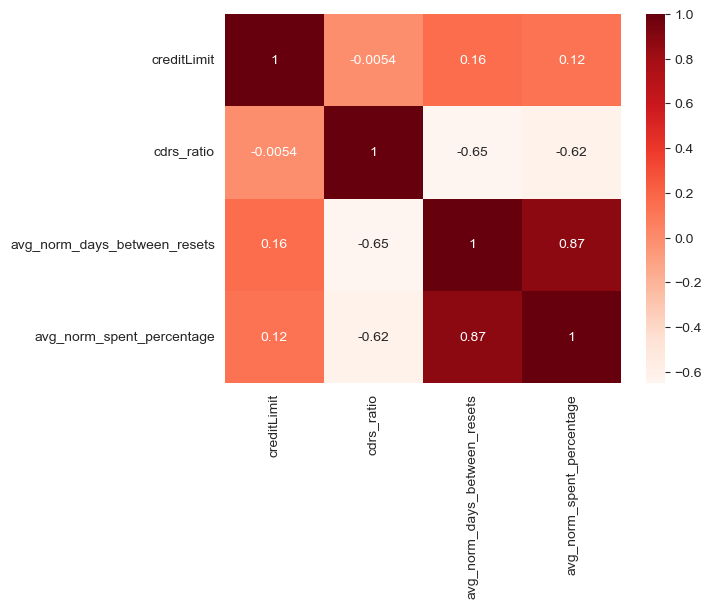

In [336]:
sns.heatmap(stability_stats_full[['creditLimit', 'cdrs_ratio', 'avg_norm_days_between_resets', 'avg_norm_spent_percentage']].corr(), cmap="Reds", annot=True)

In [304]:
both_avg_stats_is_na_accounts = stability_stats_full[(stability_stats_full['avg_norm_days_between_resets'].isnull()) & (stability_stats_full['avg_norm_spent_percentage'].isnull())]['accountNumber']
stab_df_both_avg_stats_is_na_accounts = stability_stats_full[stability_stats_full['accountNumber'].isin(both_avg_stats_is_na_accounts)]
stab_df_both_avg_stats_is_na_accounts

,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
74,112169253,7500.0,NaN,NaN,NaN,NaN
187,133296468,1000.0,NaN,NaN,NaN,NaN
315,155162628,1000.0,NaN,NaN,NaN,NaN
344,160385576,7500.0,NaN,NaN,NaN,NaN
446,175371728,2500.0,NaN,NaN,NaN,NaN
639,211045558,10000.0,NaN,NaN,NaN,NaN
772,235216553,20000.0,NaN,NaN,NaN,NaN
849,248538348,20000.0,NaN,NaN,NaN,NaN
886,253391953,500.0,NaN,NaN,NaN,NaN
1059,287527885,15000.0,NaN,NaN,NaN,NaN


In [305]:
def calculate_percentage(part, total):
    if total == 0:
        return 0  # to avoid division by zero
    percentage = (part / total) * 100
    print(f"Number {part} is {percentage}% of {total}")

In [310]:
gen_df_with_both_invalid_avg_stats = df[df['accountNumber'].isin(both_avg_stats_is_na_accounts)]
print(f'Count of account transactions where both necessary params avg (spent percentage, avg days btw resets) is nan in stability stats: {gen_df_with_both_invalid_avg_stats.shape[0]}')
calculate_percentage(gen_df_with_both_invalid_avg_stats.shape[0], df.shape[0])
print(f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_both_invalid_avg_stats[gen_df_with_both_invalid_avg_stats["isFraud"] == True].shape[0]}')

Count of account transactions where both necessary params avg (spent percentage, avg days btw resets) is nan in stability stats: 573
573 is 0.0670100982931721% of 855095
Count of frauds transactions in gen dataset by these account numbers: 0


In [311]:
df.drop(index=gen_df_with_both_invalid_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_both_avg_stats_is_na_accounts.index, inplace=True)
simple_eda(stability_stats_full)

Dimensions: 4959 rows, 6 columns
Total NA's: 5162
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4959            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3741            1         
avg_norm_days_between_resets           float64    3131            55        
cdrs_ratio                             float64    2138            2402      
cdrs_range                             category   7               2704      


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


In [320]:
stab_df_invalid_spent_avg_stats_is_na_accounts = stability_stats_full[stability_stats_full['avg_norm_spent_percentage'].isnull()]['accountNumber']
gen_df_with_invalid_spent_avg_stats = df[df['accountNumber'].isin(stab_df_invalid_spent_avg_stats_is_na_accounts)]

print(f'Count of account transactions where avg spent percentage btw resets in nan in stability stats: {gen_df_with_invalid_spent_avg_stats.shape[0]}')
calculate_percentage(gen_df_with_invalid_spent_avg_stats.shape[0], df.shape[0])
print(f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_invalid_spent_avg_stats[gen_df_with_invalid_spent_avg_stats["isFraud"] == True].shape[0]}')

Count of account transactions where avg spent percentage btw resets in nan in stability stats: 12
12 is 0.0014644969330993391% of 819394
Count of frauds transactions in gen dataset by these account numbers: 0


In [275]:
df[df['accountNumber'] == '259711806']

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud
154131,259711806,20000.0,20000.00,2016-09-13 09:44:41.000,20000.00,US,US,05,01,mobileapps,07/2032,2010-05-10,2010-05-10,784,784,REPLENISHMENT,0.00,False,False,False
154132,259711806,20000.0,20000.00,2016-09-14 09:44:41.000,6.58,US,US,05,01,mobileapps,07/2032,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False
154133,259711806,20000.0,19993.42,2016-09-16 22:04:48.000,10.80,US,US,05,01,online_subscriptions,02/2020,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False
154134,259711806,20000.0,19982.62,2016-10-01 10:43:33.500,17.38,US,US,05,01,online_subscriptions,02/2020,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False
154135,259711806,20000.0,20000.00,2016-10-15 23:22:19.000,6.58,US,US,05,01,mobileapps,07/2032,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False
154136,259711806,20000.0,19993.42,2016-10-17 06:06:18.000,10.80,US,US,05,01,online_subscriptions,02/2020,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False
154137,259711806,20000.0,19982.62,2016-11-01 01:46:42.000,17.38,US,US,05,01,online_subscriptions,02/2020,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False
154138,259711806,20000.0,20000.00,2016-11-15 21:27:06.000,6.58,US,US,05,01,mobileapps,07/2032,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False
154139,259711806,20000.0,19993.42,2016-11-16 08:33:18.000,10.80,US,US,05,01,online_subscriptions,02/2020,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False
154140,259711806,20000.0,19982.62,2016-12-01 21:12:57.000,17.38,US,US,05,01,online_subscriptions,02/2020,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False


In [321]:
df.drop(index=gen_df_with_invalid_spent_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_invalid_spent_avg_stats_is_na_accounts.index, inplace=True)
simple_eda(stability_stats_full)

Dimensions: 4903 rows, 6 columns
Total NA's: 4998
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4903            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3712            0         
avg_norm_days_between_resets           float64    3131            0         
cdrs_ratio                             float64    2137            2348      
cdrs_range                             category   7               2650      


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


In [277]:

days_avg_stat_is_na_accounts = stability_stats_full[stability_stats_full['avg_norm_days_between_resets'].isnull()]['accountNumber']
stab_df_days_avg_stats_is_na_accounts = stability_stats_full[stability_stats_full['accountNumber'].isin(days_avg_stat_is_na_accounts)]
stab_df_days_avg_stats_is_na_accounts

,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
59,110169390,15000.0,0.368713,NaN,NaN,NaN
65,110625245,500.0,0.500000,NaN,NaN,NaN
94,116858596,15000.0,0.090909,NaN,NaN,NaN
108,118650256,10000.0,0.888889,NaN,NaN,NaN
265,147940209,250.0,0.500000,NaN,NaN,NaN
318,155977598,5000.0,0.100000,NaN,NaN,NaN
321,156555865,20000.0,0.529953,NaN,NaN,NaN
559,196881494,20000.0,0.400000,NaN,NaN,NaN
675,219515030,1000.0,0.333333,NaN,NaN,NaN
676,219659566,5000.0,0.247080,NaN,NaN,NaN


In [317]:
gen_df_with_invalid_days_avg_stats = df[df['accountNumber'].isin(days_avg_stat_is_na_accounts)]
print(f'Count of account transactions where avg days btw resets in nan in stability stats: {gen_df_with_invalid_days_avg_stats.shape[0]}')
calculate_percentage(gen_df_with_invalid_days_avg_stats.shape[0], df.shape[0])
print(f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_invalid_days_avg_stats[gen_df_with_invalid_days_avg_stats["isFraud"] == True].shape[0]}')

calculate_percentage(gen_df_with_invalid_days_avg_stats[gen_df_with_invalid_days_avg_stats["isFraud"] == True].shape[0], df[df['isFraud'] == True].shape[0])

Count of account transactions where avg days btw resets in nan in stability stats: 35128
35128 is 4.110836233590241% of 854522
Count of frauds transactions in gen dataset by these account numbers: 787
787 is 6.3380848836272845% of 12417


In [280]:
df[df['accountNumber'] == '155977598']

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud
51657,155977598,5000.0,5000.00,2016-02-27 15:29:21.000,5000.00,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,REPLENISHMENT,0.00,False,False,False
51658,155977598,5000.0,5000.00,2016-02-28 15:29:21.000,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False
51659,155977598,5000.0,4977.65,2016-03-14 20:19:49.500,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False
51660,155977598,5000.0,5000.00,2016-03-30 01:10:18.000,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False
51661,155977598,5000.0,4977.65,2016-04-14 13:23:21.500,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False
51662,155977598,5000.0,5000.00,2016-04-30 01:36:25.000,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False
51663,155977598,5000.0,4977.65,2016-05-15 10:36:07.500,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False
51664,155977598,5000.0,5000.00,2016-05-30 19:35:50.000,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False
51665,155977598,5000.0,4977.65,2016-06-14 15:05:05.500,22.35,US,US,05,01,online_subscriptions,04/2020,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False
51666,155977598,5000.0,5000.00,2016-06-29 10:34:21.000,34.55,US,US,02,08,food,12/2031,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,True,False,False


In [318]:
df.drop(index=gen_df_with_invalid_days_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_days_avg_stats_is_na_accounts.index, inplace=True)
simple_eda(stability_stats_full)

Dimensions: 4904 rows, 6 columns
Total NA's: 5001
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4904            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3712            1         
avg_norm_days_between_resets           float64    3131            0         
cdrs_ratio                             float64    2137            2349      
cdrs_range                             category   7               2651      


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


In [329]:
cdrs_ratio_is_0_accounts = stability_stats_full[stability_stats_full['cdrs_ratio'] == 0]['accountNumber']
stab_df_cdrs_ratio_is_0 = stability_stats_full[stability_stats_full['accountNumber'].isin(cdrs_ratio_is_0_accounts)]
stab_df_cdrs_ratio_is_0

,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
27,104048186,7500.0,1.000000,1.000000,0.0,NaN
39,105518929,500.0,0.519273,0.368132,0.0,NaN
52,108300020,20000.0,1.000000,1.000000,0.0,NaN
86,114895301,5000.0,0.448404,0.340336,0.0,NaN
103,118240481,15000.0,0.448924,0.430108,0.0,NaN
...,...,...,...,...,...,...
4922,985848672,5000.0,0.354490,0.560417,0.0,NaN
4928,987150360,2500.0,1.000000,1.000000,0.0,NaN
4965,993959615,5000.0,0.356652,0.401070,0.0,NaN
4986,997862042,500.0,0.473224,0.395349,0.0,NaN


In [331]:
gen_df_cdrs_ratio_is_0 = df[df['accountNumber'].isin(cdrs_ratio_is_0_accounts)]
print(f'Count of account transactions where cdrs ratio is 0 in stability stats: {gen_df_cdrs_ratio_is_0.shape[0]}')
calculate_percentage(gen_df_cdrs_ratio_is_0.shape[0], df.shape[0])
print(f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_cdrs_ratio_is_0[gen_df_cdrs_ratio_is_0["isFraud"] == True].shape[0]}')

calculate_percentage(gen_df_cdrs_ratio_is_0[gen_df_cdrs_ratio_is_0["isFraud"] == True].shape[0], df[df['isFraud'] == True].shape[0])


Count of account transactions where cdrs ratio is 0 in stability stats: 70170
70170 is 8.563771232465443% of 819382
Count of frauds transactions in gen dataset by these account numbers: 1004
1004 is 8.632846087704213% of 11630


In [332]:
df.drop(index=gen_df_cdrs_ratio_is_0.index, inplace=True)
stability_stats_full.drop(index=cdrs_ratio_is_0_accounts.index, inplace=True)
simple_eda(stability_stats_full)

Dimensions: 4601 rows, 6 columns
Total NA's: 4696
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3507            0         
avg_norm_days_between_resets           float64    2964            0         
cdrs_ratio                             float64    2136            2348      
cdrs_range                             category   7               2348      


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


In [343]:
stability_stats_full_test_pred_df = stability_stats_full.copy()
stability_stats_full_test_pred_df.dropna(inplace=True)
cdrs_range_encoder = LabelEncoder()

stability_stats_full_test_pred_df['cdrs_range_encoded'] = cdrs_range_encoder.fit_transform(stability_stats_full_test_pred_df['cdrs_range'])
simple_eda(stability_stats_full_test_pred_df)


Dimensions: 2253 rows, 7 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     2253            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    2222            0         
avg_norm_days_between_resets           float64    1845            0         
cdrs_ratio                             float64    2136            0         
cdrs_range                             category   7               0         
cdrs_range_encoded                     int32      7               0         


C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtype = str(dtypes[i])
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distinct_count = uniq[i]
C:\Users\gorba\AppData\Local\Temp\ipykernel_25768\2750437330.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  na_count = na_val[i]


In [353]:
cdrs_range_encoded_weights = compute_class_weight('balanced', classes=stability_stats_full_test_pred_df['cdrs_range_encoded'].unique(), y=stability_stats_full_test_pred_df['cdrs_range_encoded'])
print(cdrs_range_encoded_weights)

[  0.35446822   3.21857143   0.44702381   0.64242943  18.93277311
  80.46428571 107.28571429]


In [355]:
X_stats_full = stability_stats_full_test_pred_df.drop(columns=['cdrs_range', 'cdrs_range_encoded', 'cdrs_ratio', 'accountNumber'])
Y_stats_full = stability_stats_full_test_pred_df['cdrs_range_encoded']

X_stats_full_train, X_stats_full_test, Y_stats_full_train, Y_stats_full_test = train_test_split(X_stats_full, Y_stats_full, test_size=0.2, random_state=101)

classifier = LogisticRegression(random_state=101, solver='sag', multi_class='auto')
classifier.fit(X_stats_full_train, Y_stats_full_train)

pred = classifier.predict(X_stats_full_test)

accuracy = accuracy_score(Y_stats_full_test, pred)

print('General accuracy(Logistic regression): ', accuracy * 100)

General accuracy(Logistic regression):  41.68514412416852


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [349]:
classifier = GaussianNB()
classifier.fit(X_stats_full_train, Y_stats_full_train)

pred = classifier.predict(X_stats_full_test)

accuracy = accuracy_score(Y_stats_full_test, pred)

print('General accuracy(GaussianNB): ', accuracy * 100)


General accuracy(GaussianNB):  48.55875831485588


In [350]:
classifier = neighbors.KNeighborsClassifier(n_neighbors=25)
classifier.fit(X_stats_full_train, Y_stats_full_train)

pred = classifier.predict(X_stats_full_test)

accuracy = accuracy_score(Y_stats_full_test, pred)

print('General accuracy(KNeighborsClassifier): ', accuracy * 100)

General accuracy(KNeighborsClassifier):  72.72727272727273


In [ ]:
# Creating a new feature (MATCH ENTERED CVV OR NOT)
# df['cvv_matched_status'] = [True if actual_cvv == entered_cvv else False for actual_cvv, entered_cvv in zip(df['cardCVV'], df['enteredCVV'])]

In [ ]:
# Creating a new feature (address change count on each transaction according to chronology)

In [ ]:
# Creating a new feature (client`s solvency ratio)

In [ ]:


# come up smth with account open date
# Find frequent transaction per similar account number (transaction date time)

# fill na with mode
# add feature that indicates about frequent address changing
# replace two cvv columns on matching marker feature
# sample data
# investigate about scaling ??
# divide train test split
# investigate about hyperparameters tuning tools
# build models with benchmarks
# add pipeline to save models
# add controller to test transaction/group of transaction on fraud


# ?? investigate how to process different types of anomalies (point, context, group)
# ?? Model types
# ?? Hybrid - cluster + classifier
# ?? Ensemble